#**Naive Bayes Classifier for Classification**

The data considered was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry
Becker (Data Mining and Visualization, Silicon Graphics). 

The key task is to determine whether
a person makes over $50K a year. The file adult.csv contains the dataset required to solve the task.


In [1]:
#importing the basic required libraries
import numpy as np
import pandas as pd

##**Reading data from the given data format(csv file):**

In [2]:
from google.colab import files 
uploaded= files.upload() #uploading the files

Saving adult.csv to adult.csv


In [3]:
import io
#creating dataframes from the csv file
df=pd.read_csv(io.BytesIO(uploaded['adult.csv'])) 

##**Cleaning and Preparing the Data:**

In [4]:
df.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [5]:
df.columns

Index(['39', ' State-gov', '77516', ' Bachelors', '13', ' Never-married',
       ' Adm-clerical', ' Not-in-family', ' White', ' Male', '2174', '0', '40',
       ' United-States', ' <=50K'],
      dtype='object')

###**Renaming the columns/variables  with meaningful column/variable names:**

In [6]:
df.rename(columns={"39":"Age"},inplace=True)
df.rename(columns={"77516":"fnlwgt"},inplace=True) 
df.rename(columns={"13":"Years of education"},inplace=True)
df.rename(columns={" Male":"Sex"},inplace=True)
df.rename(columns={" White":"Race"},inplace=True)
df.rename(columns={"2174":"Capital gain"},inplace=True)
df.rename(columns={"0":"Capital loss"},inplace=True)
df.rename(columns={"40":"Working hours per week"},inplace=True)
df.rename(columns={" Bachelors":"Education"},inplace=True)
df.rename(columns={" State-gov":"Work Class"},inplace=True)
df.rename(columns={' Never-married':"Marital status"},inplace=True)
df.rename(columns={' Adm-clerical':"Occupation"},inplace=True)
df.rename(columns={' Not-in-family':"Relationship"},inplace=True)
df.rename(columns={' United-States':"Native Country"},inplace=True)

###**Mapping the categorical variable ' <=50K' to numerical values to create a new variable '>50K' :**

In [7]:
df['>50K'] = df[' <=50K'].map({' <=50K':0, ' >50K':1}) 

In [8]:
df=df.drop([' <=50K'],axis=1) #dropping the now redundant ' <=50K' variable

###**Dealing with incomplete/meaningless data in a few rows:**
Few rows were found to be containing the string value ' ?' which had no meaningful inferance/data. Hence, these rows have been removed from our final dataframe.

In [9]:
for i in range(0,len(df)):
  for variable in df.columns:
    try:
      if df.loc[i,variable]==' ?':
         df.drop(i,axis=0,inplace=True)
    except:
      pass

###**Checking for Missing values in the data:**

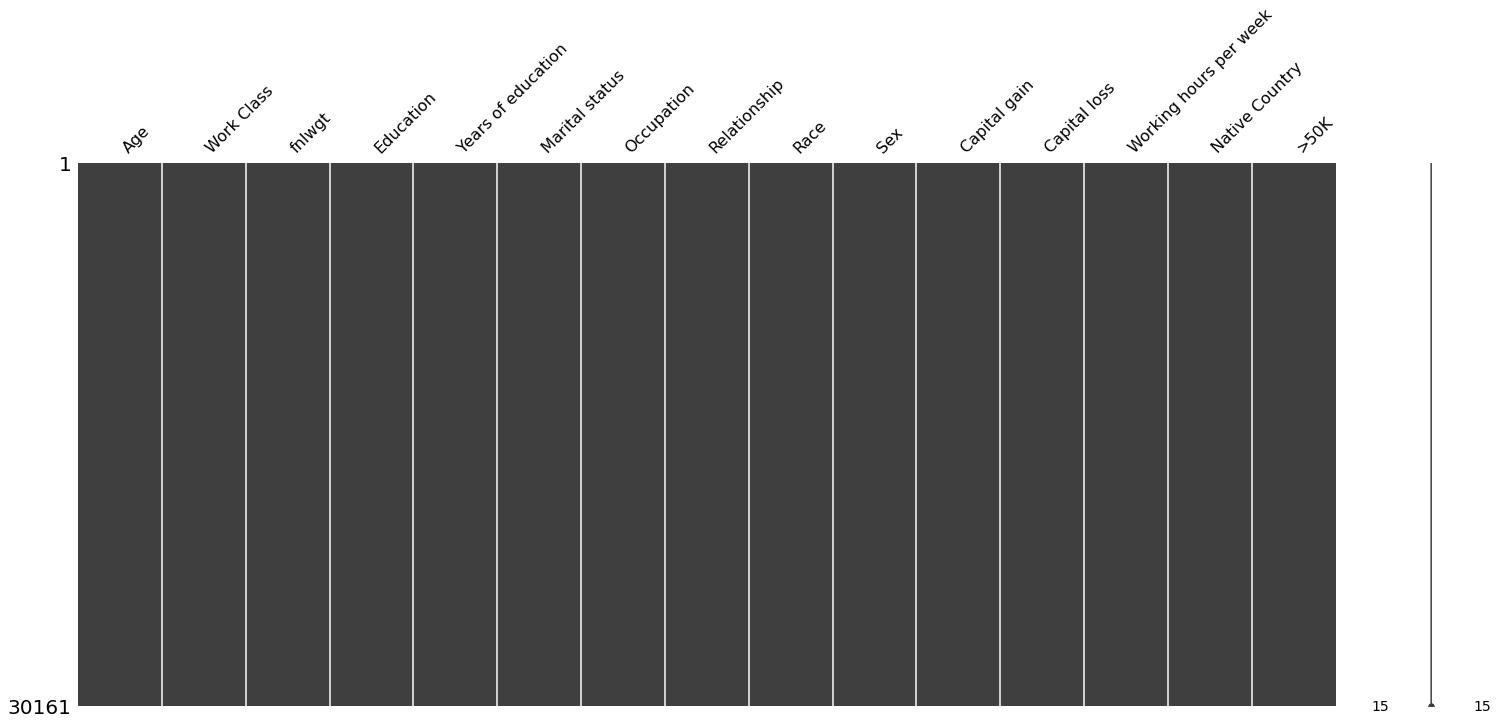

In [10]:
import missingno as msno 
msno.matrix(df) #visualizing the missing data/NaN values in the dataframe

**Inferance:**
* There are no NaN/missing values in the data

##**Feature Engineering:**

In [11]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
l=np.array(['Age', 'Years of education',
       'Capital gain', 'Capital loss', 'Working hours per week']) #variables contatining quantitative non-categorical data

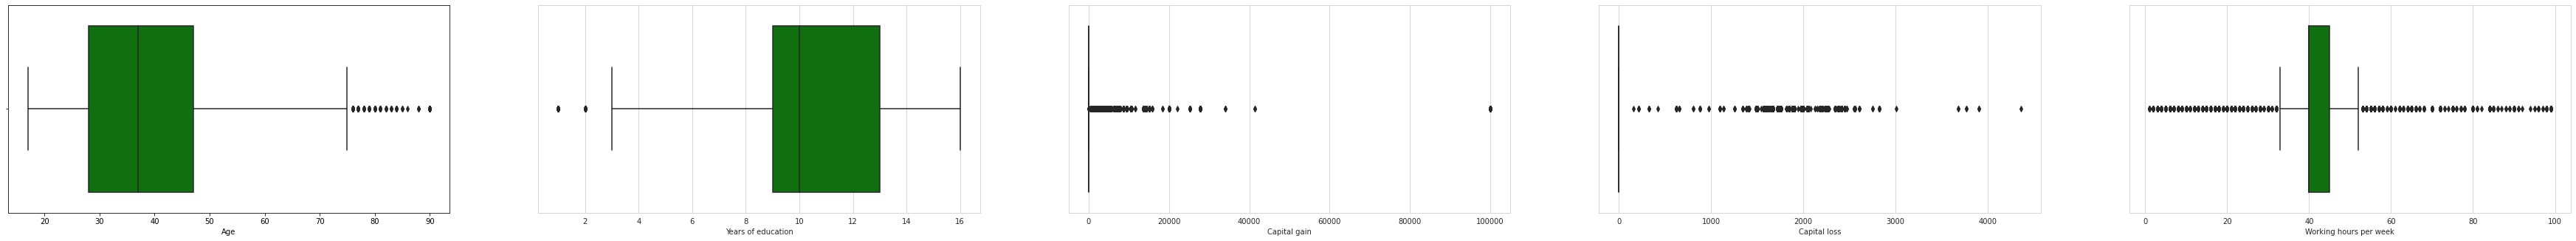

In [13]:
# Plotting a box plot to show the distribution of quantitative data

plt.figure(figsize=(500,30))
number_of_columns=39
number_of_rows = len(l)-1/number_of_columns
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x=df[l[i]],y=None,color='green')

**Key Inferance usuful for our analysis:**
* There are a significant number of outliers found in each column/variable.
* From the the box plot of the variable “Working hours per week”, we see that the mean number of working hours per week is around 40 and more than 50% of the people taking part in the survey, work between 40 and 45 hours per week.
* From the the box plot of the variable "Capital gain" and "Capital loss", we see that more than 50% of the variables "Capital gain" and "Capital loss" are zeros.



###**1. Creating a new variable called “Working hour level”:**

From the the box plot of the variable “Working hours per week”, we see that the mean number of working hours per week is around 40 and at least 50% of the people taking part in the survey, work between 40 and 45 hours per week.

Therefore, we will group the working hours in 5 categories which we consider relevant:

* less than 40 hours per week
* between 40 and 45 hours per week
* between 45 and 60 hours per week
* between 60 and 80 hours per week, and
* more than 80 hours per week,

and we will create a new factor variable called “Working hour level” with 5 levels corresponding to these 5 categories:

**Creating a categorical variable “Working hour level” from the variable 'Working hours per week':**

And since the categories have a naturally increasing order, they can be converted to numbers (e.g. 1, 2, 3, 4, 5) preserving the order. These are called ordinals.

In [14]:
for i in df.index:
  if df.loc[i,'Working hours per week']<40:
    x=1
  if df.loc[i,'Working hours per week']>=40 and df.loc[i,'Working hours per week']<=45: # we create the category " between_40_and_45" with greater than or equal and less than or equal sign, because we want the range of this category to correspond to the span of the data points between the first and the third quartile.
    x=2
  if df.loc[i,'Working hours per week']>45 and df.loc[i,'Working hours per week']<=60:
    x=3
  if df.loc[i,'Working hours per week']>60 and df.loc[i,'Working hours per week']<=80:
    x=4
  if df.loc[i,'Working hours per week']>80:
    x=5

  df.loc[i,'Working hour level']=x


###**2. Creating a new variable called “Native Region”:**

In [15]:
df['Native Country'].nunique()

41

We can see that the factor variable “Native Country” has 41 different categories. If we build a predictive model with “Native Country” as a covariate, we will end up with 41 additional degrees of freedom due to this categorical variable. This will complicate unnecessarily the analysis and might lead to overfitting. Hence, it is better to group the native countries into several global regions. This coarsening of the data also makes the interpretation of the results easier to comprehend.

Below we create the new variable “native_region”, where we group the countries by global regions. We first define the regions:

**Asia_East** <- (" Cambodia", " China", " Hong", " Laos", " Thailand",
               " Japan", " Taiwan", " Vietnam")

**Asia_Central** <- (" India", " Iran")

**Central_America** <- (" Cuba", " Guatemala", " Jamaica", " Nicaragua", 
                     " Puerto-Rico",  " Dominican-Republic", " El-Salvador", 
                     " Haiti", " Honduras", " Mexico", " Trinadad&Tobago")

**South_America** <- (" Ecuador", " Peru", " Columbia")


**Europe_West** <- (" England", " Germany", " Holand-Netherlands", " Ireland", 
                 " France", " Greece", " Italy", " Portugal", " Scotland")

**Europe_East** <- (" Poland", " Yugoslavia", " Hungary")

**Creating a categorical variable “Native Region” from the categorical variable “Native Country”:**

In [16]:
Asia_East= ("Asia_East"," Cambodia", " China", " Hong", " Laos", " Thailand", " Japan", " Taiwan", " Vietnam",' Philippines')
Asia_Central= ("Asia_Central"," India", " Iran")
North_America= ("North_America",' United-States',' Outlying-US(Guam-USVI-etc)',' Canada',' United-States'," Cuba", " Guatemala", " Jamaica", " Nicaragua", " Puerto-Rico", " Dominican-Republic", " El-Salvador", " Haiti", " Honduras", " Mexico", " Trinadad&Tobago")
South_America= ("South_America",' South'," Ecuador", " Peru", " Columbia")
Europe_West= ("Europe_West"," England", " Germany", " Holand-Netherlands", " Ireland", " France", " Greece", " Italy", " Portugal", " Scotland")
Europe_East= ("Europe_East"," Poland", " Yugoslavia", " Hungary")

Regions=[Asia_East,Asia_Central,North_America,South_America,Europe_West,Europe_East]

In [17]:
for i in df.index:
  for region in Regions:
       if df.loc[i,'Native Country'] in region :
           df.loc[i,'Native Region']= region[0]

In [18]:
df['Native Region'].unique()

array(['North_America', 'Asia_Central', 'Europe_West', 'Asia_East',
       'Europe_East', 'South_America'], dtype=object)

In [19]:
df.drop(['Native Country'],axis=1,inplace=True) #dropping the now assumably insignificant 'Native Country' variable

###**3. Creating new variables called "capital_gain" and "capital_loss":**

In [20]:
len(df[df['Capital gain']==0])/len(df)

0.9158847518318358

In [21]:
len(df[df['Capital loss']==0])/len(df)

0.9526872451178674

* The percentage of zeros in "Capital gain" is very big (i.e. approx 91.59%)
* and the percentage of zeros in "Capital loss" is also very high (i.e. approx 95.27%)

We are going to create two new categorical variables – “cap_gain” and “cap_loss”. We generate the new variables by grouping the existing variables "Capital gain" and "Capital loss" into three categories. We do this because there are too many zeros in the variables "Capital gain" and "Capital loss" and this can seriously disrupt the analysis.


In [22]:
nonzero_capital_gain_df= df[df["Capital gain"]!=0]
nonzero_capital_loss_df= df[df["Capital loss"]!=0]

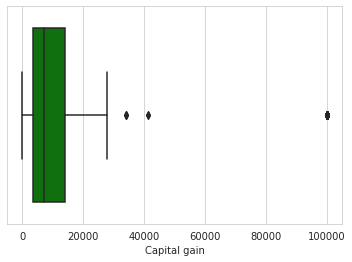

In [23]:
sns.set_style('whitegrid')
sns.boxplot(x=nonzero_capital_gain_df["Capital gain"],y=None,color='green')

From the box plot we see that, indeed, the bulk of the data is between 3,000 and 15,000 dollars

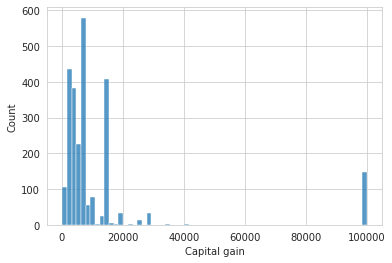

In [24]:
sns.histplot(data=nonzero_capital_gain_df, x="Capital gain")

The histogram confirms once more what we have already established, namely, that the majority of people with positive capital gain have a capital gain between 0 and 25,000 dollars, and there are also about 150 people with capital gain of around 100,000 dollars. We also note that the biggest number of people with positive capital gain are those with about 5,000 dollars.

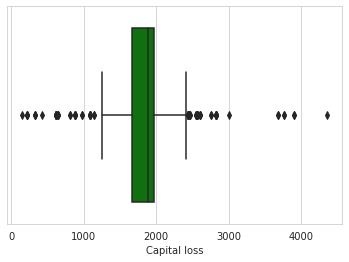

In [25]:
sns.set_style('whitegrid')
sns.boxplot(x=nonzero_capital_loss_df["Capital loss"],y=None,color='green')

From the box plot we observe that most values are between 1,700 and 2,000 dollars (as already stated), and there are a lot of outliers represented by the filled black dots. 

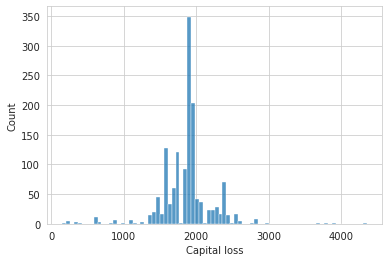

In [26]:
sns.histplot(data=nonzero_capital_loss_df, x="Capital loss")

From the histogram we also see that the biggest number of people have a capital loss of about 1,875 dollars.

The box plots and histograms illustrate visually the results of the summary statistics for the nonzero capital gain and capital loss. Based on these results, we will group the values of the variables “capital_loss” and “capital gain” into categories and we will create two new factor variables called “cap_gain” and “cap_loss”. We do the grouping in the following way:

Capital gain:

* We mark all values of “capital_gain” which are less than the first quartile of the nonzero capital gain (which is equal to 3464) as “Low”; 
* all values that are between the first and third quartile (between 3464 and 14080) - as “Medium”; 
* and all values greater than or equal to the third quartile are marked as “High”.

Capital loss:

* We mark all values of “capital_loss” which are less than the first quartile of the nonzero capital gain (which is equal to 1672) as “Low”; 
* all values that are between the first and third quartile (between 1672 and 1977) - as “Medium”; 
* and all values greater than or equal to the third quartile are marked as “High”.

In [27]:
for i in df.index:
  if df.loc[i,'Capital gain']<3464:
    x="low"
  if df.loc[i,'Capital gain']>=3464 and df.loc[i,'Capital gain']<14080:
    x="medium"
  if df.loc[i,'Capital gain']>=14080:
    x="high"

  df.loc[i,'capital_gain']=x

In [28]:
for i in df.index:
  if df.loc[i,'Capital loss']<1672:
    x="low"
  if df.loc[i,'Capital loss']>=1672 and df.loc[i,'Capital loss']<1977:
    x="medium"
  if df.loc[i,'Capital loss']>=1977:
    x="high"

  df.loc[i,'capital_loss']=x

In [29]:
df.drop(['Capital gain','Capital loss'],axis=1,inplace=True)

##**Exploratory Data Analysis and Visualization:**

**Background Research:** 
* If two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking.
* Incorporated self employment: Refers to people who work for themselves in corporate entities. Unincorporated self employment: Refers to people who work for themselves in other legal entities.

In [46]:
#importing the libraries required for visualization
import os
import torch
import torchvision
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [31]:
l=np.array(['Age', 'Years of education', 'Working hours per week']) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

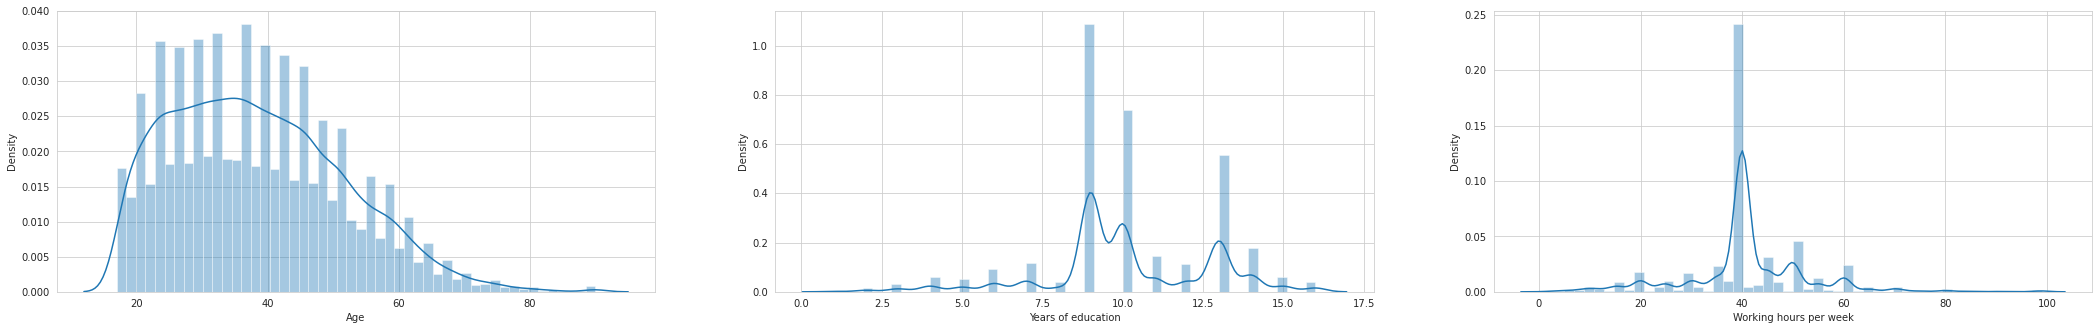

In [32]:
#Using Kernel density estimate (kde) for plotting the shape of distributions to check the linearity of variables and look for skewness of features
plt.figure(figsize=(500,30))

for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

**Inferance:**
* Most people in the given dataset are in the age group 20 to 60 years of age.
* Most people in the given dataset have about 8.5 years of education.
* Most people in the given dataset work about 40 hours per week.

Text(0, 0.5, 'Probability of making >50k')

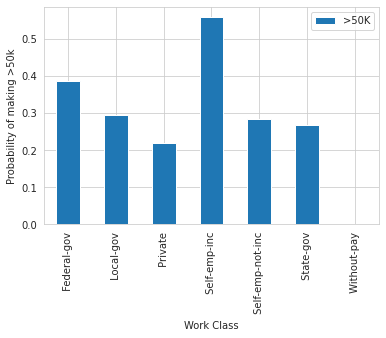

In [33]:
x=df[['Work Class', '>50K']].groupby('Work Class').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Work Class')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* People who are employed under 'Incorporated self employment' have the highest probability of making >50K followed by those who's work class is 'Fedral Government'.
* People who are employed under the 'Private' work class have the least probability of making >50k. 

Text(0, 0.5, 'Probability of making >50k')

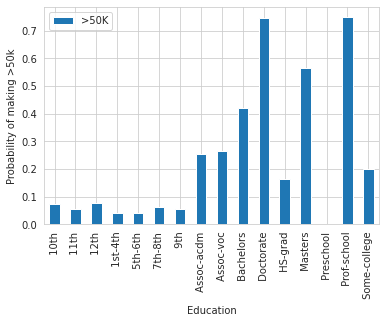

In [34]:
x=df[['Education', '>50K']].groupby('Education').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Education')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* People who had completed their education upto a Professor-School, Doctorate or Masters degree(in the decreasing order of mention) had a higher probaibility of earning well.
* Whereas people who had only completed their education upto the schooling level are expected to make significantly less when compared to the others.

Text(0, 0.5, 'Probability of making >50k')

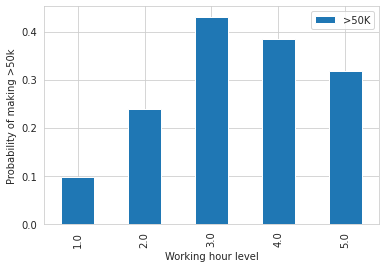

In [35]:
x=df[['Working hour level', '>50K']].groupby('Working hour level').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Working hour level')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* People who worked between 45-60(45 not included) hours per week(working hour level 3) had highest probability of making >50k, followed by those who worked between 60-80(60 not included) hours per week(working hour level 4).
* Higher working hours does not accurately mean higher payoffs. (i.e. working hour level 5 has lesser probability of paying off well when compared to level 3 and 4).

Text(0, 0.5, 'Probability of making >50k')

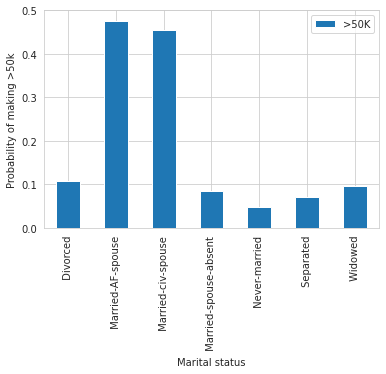

In [36]:
x=df[['Marital status', '>50K']].groupby('Marital status').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Marital status')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* People who were married to a spouse in the Armed Forces or a civilian spouse had a higher probability of making >50k.
* People who were never married had the least of probability.

In [37]:
df[['Relationship', '>50K']].groupby('Relationship').mean()

,>50K
Relationship,
Husband,0.455669
Not-in-family,0.106537
Other-relative,0.039370
Own-child,0.014330
Unmarried,0.066314
Wife,0.493599


Text(0, 0.5, 'Probability of making >50k')

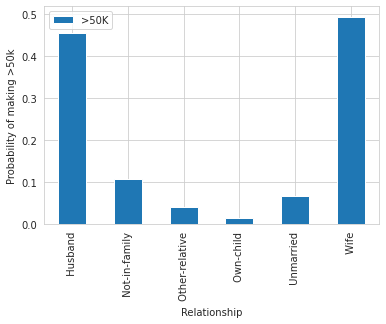

In [38]:
x=df[['Relationship', '>50K']].groupby('Relationship').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Relationship')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* 

Text(0, 0.5, 'Probability of making >50k')

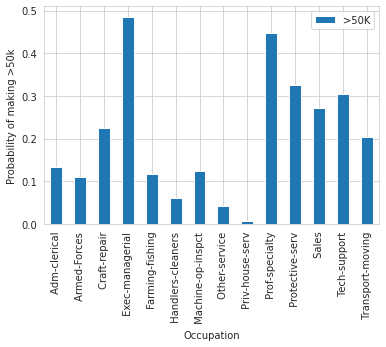

In [39]:
x=df[['Occupation', '>50K']].groupby('Occupation').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Occupation')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* People who were employed as executive managers, professional speciality and protective services made considerably more than the others.
* People employed under private house services, machine operations, farmimg, fishing and cleaning services made significantly lesser than the rest.

Text(0, 0.5, 'Probability of making >50k')

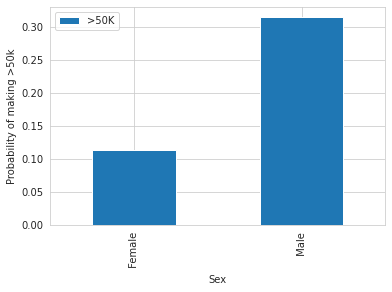

In [40]:
x=df[['Sex', '>50K']].groupby('Sex').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Sex')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* The probability of men making >50k is found to be much higher than that of female. 
* This might be due to the fact that in the 1900's women were barely allowed to work, and even if they did they were neither given work in the positions of higher order nor paid equally well as their male counterparts.

Text(0, 0.5, 'Probability of making >50k')

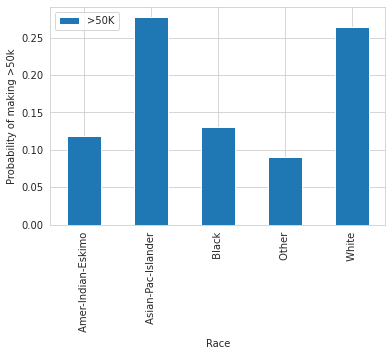

In [41]:
x=df[['Race', '>50K']].groupby('Race').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Race')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* We see that the people belonging to the race 'Asian Pacific Islander' and 'White' have a higher probability of making >50k when compared to the 'Black', 'Indian-American', 'Eskimo' or other groups.

Text(0, 0.5, 'Probability of making >50k')

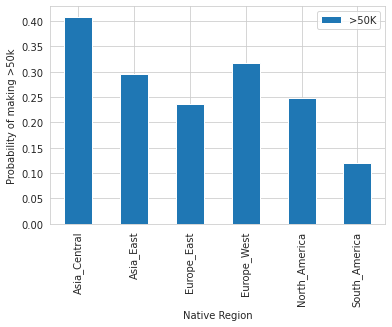

In [42]:
x=df[['Native Region', '>50K']].groupby('Native Region').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('Native Region')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* We see that the people natively belonging to Central Asia and Western Europe have the highest probability of making >50k.
* Whereas those who's nativity is from Southern America have the least probability of making >50k.

Text(0, 0.5, 'Probability of making >50k')

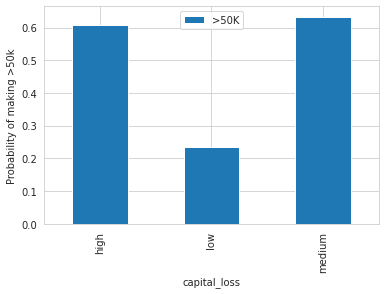

In [43]:
# A capital loss is the loss incurred when a capital asset, such as an investment or real estate, decreases in value. 
# This loss is not realized until the asset is sold for a price that is lower than the original purchase price.
x=df[['capital_loss', '>50K']].groupby('capital_loss').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('capital_loss')
plt.set_ylabel('Probability of making >50k') 

Text(0, 0.5, 'Probability of making >50k')

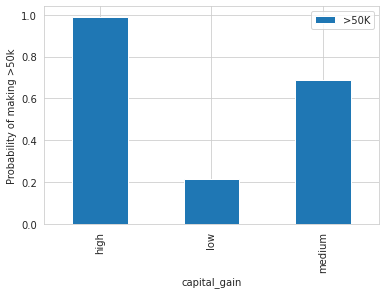

In [44]:
#A capital gain is an increase in the value of an asset or investment resulting from the price appreciation of the asset or investment.
x=df[['capital_gain', '>50K']].groupby('capital_gain').mean()
plt= x.plot(kind='bar')

plt.set_xlabel('capital_gain')
plt.set_ylabel('Probability of making >50k') 

**Inferance:**
* Those people with a higher capital gain are generally more likely to make >$50k.

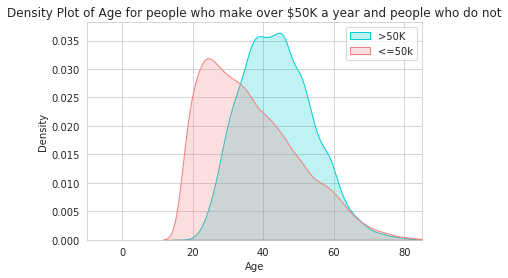

In [47]:
ax = sns.kdeplot(df["Age"][df['>50K'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["Age"][df['>50K'] == 0], color="lightcoral", shade=True)
plt.legend(['>50K', '<=50k'])
plt.title('Density Plot of Age for people who make over $50K a year and people who do not')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

**Inferance:**
* It can be said to be a general inferance that people who make >50k tend to have older age than those who make <50k.

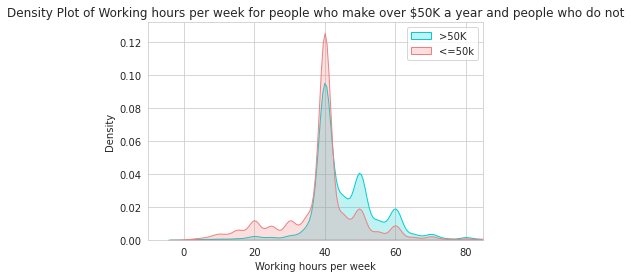

In [48]:
ax = sns.kdeplot(df['Working hours per week'][df['>50K'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(df['Working hours per week'][df['>50K'] == 0], color="lightcoral", shade=True)
plt.legend(['>50K', '<=50k'])
plt.title('Density Plot of Working hours per week for people who make over $50K a year and people who do not')
ax.set(xlabel='Working hours per week')
plt.xlim(-10,85)
plt.show()

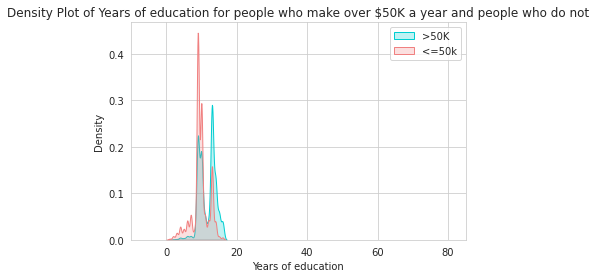

In [49]:
ax = sns.kdeplot(df['Years of education'][df['>50K'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(df['Years of education'][df['>50K'] == 0], color="lightcoral", shade=True)
plt.legend(['>50K', '<=50k'])
plt.title('Density Plot of Years of education for people who make over $50K a year and people who do not')
ax.set(xlabel='Years of education')
plt.xlim(-10,85)
plt.show()

**Inferance:**
* It is a general inferance from the above density plot that those who make >50k have greater number of years of education when compared to those who make <50k.

In [50]:
corr_matrix = df.corr()
corr_matrix

,Age,fnlwgt,Years of education,Working hours per week,>50K,Working hour level
Age,1.000000,-0.076511,0.043525,0.101599,0.242000,0.100333
fnlwgt,-0.076511,1.000000,-0.044954,-0.022889,-0.008978,-0.022610
Years of education,0.043525,-0.044954,1.000000,0.152528,0.335317,0.145181
Working hours per week,0.101599,-0.022889,0.152528,1.000000,0.229480,0.905854
>50K,0.242000,-0.008978,0.335317,0.229480,1.000000,0.234696
Working hour level,0.100333,-0.022610,0.145181,0.905854,0.234696,1.000000


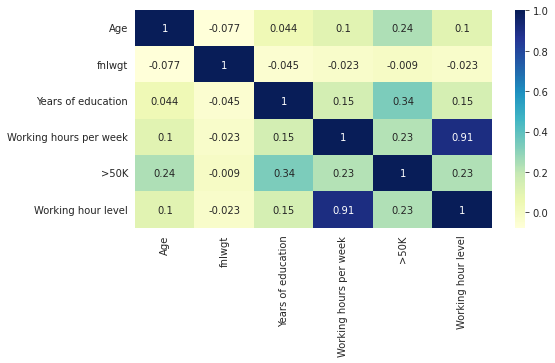

In [51]:
#Visualizing the correlation matrix using a heatmap in seaborn
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, cmap='YlGnBu',annot=True)

We observe that the correlation between the "Working hours per week" and "Working hour level" is very high. Hence we remove the former variable to remove redundancy.

In [52]:
df.drop('Working hours per week', axis=1,inplace=True)

##**Preprocessing the Data for Analysis:**

In [53]:
#Identifying the numerical and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes('object').columns.tolist()

In [54]:
categorical_cols

['Work Class',
 'Education',
 'Marital status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Native Region',
 'capital_gain',
 'capital_loss']

####**Scaling Numeric Features**
A good practice is to scale numeric features to a small range of values e.g. 
(
0
,
1
)
 or 
(
−
1
,
1
)
. Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

In [55]:
df[numeric_cols].describe()

,Age,fnlwgt,Years of education,>50K,Working hour level
count,30161.000000,3.016100e+04,30161.000000,30161.000000,30161.000000
mean,38.437883,1.897976e+05,10.121216,0.248931,2.045589
std,13.134882,1.056527e+05,2.549983,0.432401,0.764435
min,17.000000,1.376900e+04,1.000000,0.000000,1.000000
25%,28.000000,1.176280e+05,9.000000,0.000000,2.000000
50%,37.000000,1.784290e+05,10.000000,0.000000,2.000000
75%,47.000000,2.376300e+05,13.000000,0.000000,2.000000
max,90.000000,1.484705e+06,16.000000,1.000000,5.000000


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(df[numeric_cols])

df[numeric_cols] = scaler.transform(df[numeric_cols])

In [57]:
df[numeric_cols].describe()

,Age,fnlwgt,Years of education,>50K,Working hour level
count,30161.000000,30161.000000,30161.000000,30161.000000,30161.000000
mean,0.293670,0.119671,0.608081,0.248931,0.261397
std,0.179930,0.071827,0.169999,0.432401,0.191109
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.070607,0.533333,0.000000,0.250000
50%,0.273973,0.111942,0.600000,0.000000,0.250000
75%,0.410959,0.152189,0.800000,0.000000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000


####**Encoding Categorical Data**
Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [58]:
df[categorical_cols].nunique()

Work Class         7
Education         16
Marital status     7
Occupation        14
Relationship       6
Race               5
Sex                2
Native Region      6
capital_gain       3
capital_loss       3
dtype: int64

In [59]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

encoder.fit(df[categorical_cols])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [60]:
encoder.categories_

[array([' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc',
        ' Self-emp-not-inc', ' State-gov', ' Without-pay'], dtype=object),
 array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 array([' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
        ' Unmarried', ' Wife'], dtype=object),
 array(['

In [61]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Work Class_ Federal-gov', 'Work Class_ Local-gov', 'Work Class_ Private', 'Work Class_ Self-emp-inc', 'Work Class_ Self-emp-not-inc', 'Work Class_ State-gov', 'Work Class_ Without-pay', 'Education_ 10th', 'Education_ 11th', 'Education_ 12th', 'Education_ 1st-4th', 'Education_ 5th-6th', 'Education_ 7th-8th', 'Education_ 9th', 'Education_ Assoc-acdm', 'Education_ Assoc-voc', 'Education_ Bachelors', 'Education_ Doctorate', 'Education_ HS-grad', 'Education_ Masters', 'Education_ Preschool', 'Education_ Prof-school', 'Education_ Some-college', 'Marital status_ Divorced', 'Marital status_ Married-AF-spouse', 'Marital status_ Married-civ-spouse', 'Marital status_ Married-spouse-absent', 'Marital status_ Never-married', 'Marital status_ Separated', 'Marital status_ Widowed', 'Occupation_ Adm-clerical', 'Occupation_ Armed-Forces', 'Occupation_ Craft-repair', 'Occupation_ Exec-managerial', 'Occupation_ Farming-fishing', 'Occupation_ Handlers-cleaners', 'Occupation_ Machine-op-inspct', 'Occupat

In [62]:
df[encoded_cols] = encoder.transform(df[categorical_cols])

In [63]:
df.columns

Index(['Age', 'Work Class', 'fnlwgt', 'Education', 'Years of education',
       'Marital status', 'Occupation', 'Relationship', 'Race', 'Sex', '>50K',
       'Working hour level', 'Native Region', 'capital_gain', 'capital_loss',
       'Work Class_ Federal-gov', 'Work Class_ Local-gov',
       'Work Class_ Private', 'Work Class_ Self-emp-inc',
       'Work Class_ Self-emp-not-inc', 'Work Class_ State-gov',
       'Work Class_ Without-pay', 'Education_ 10th', 'Education_ 11th',
       'Education_ 12th', 'Education_ 1st-4th', 'Education_ 5th-6th',
       'Education_ 7th-8th', 'Education_ 9th', 'Education_ Assoc-acdm',
       'Education_ Assoc-voc', 'Education_ Bachelors', 'Education_ Doctorate',
       'Education_ HS-grad', 'Education_ Masters', 'Education_ Preschool',
       'Education_ Prof-school', 'Education_ Some-college',
       'Marital status_ Divorced', 'Marital status_ Married-AF-spouse',
       'Marital status_ Married-civ-spouse',
       'Marital status_ Married-spouse-absent

In [64]:
df=df.drop(categorical_cols, axis = 1)

In [65]:
df.head()

,Age,fnlwgt,Years of education,>50K,Working hour level,Work Class_ Federal-gov,Work Class_ Local-gov,Work Class_ Private,Work Class_ Self-emp-inc,Work Class_ Self-emp-not-inc,Work Class_ State-gov,Work Class_ Without-pay,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,Education_ 7th-8th,Education_ 9th,Education_ Assoc-acdm,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Marital status_ Divorced,Marital status_ Married-AF-spouse,Marital status_ Married-civ-spouse,Marital status_ Married-spouse-absent,Marital status_ Never-married,Marital status_ Separated,Marital status_ Widowed,Occupation_ Adm-clerical,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Relationship_ Husband,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Amer-Indian-Eskimo,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Sex_ Female,Sex_ Male,Native Region_Asia_Central,Native Region_Asia_East,Native Region_Europe_East,Native Region_Europe_West,Native Region_North_America,Native Region_South_America,capital_gain_high,capital_gain_low,capital_gain_medium,capital_loss_high,capital_loss_low,capital_loss_medium
0,0.452055,0.047277,0.800000,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.287671,0.137244,0.533333,0.0,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.493151,0.150212,0.400000,0.0,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.150685,0.220703,0.800000,0.0,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.273973,0.184109,0.866667,0.0,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


##**Using the Naive Bayes Classifier Model for Classification:**

###**Making the Training, Validation and Test Sets**
While building real-world machine learning models, it is quite common to split the dataset into three parts:

**Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique.

**Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well. Learn more here.

**Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.


As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)

In [68]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (28652, 74)
val_df.shape : (1509, 74)


###**Identifying Input and Target Columns**
Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the Date column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [69]:
df.columns

Index(['Age', 'fnlwgt', 'Years of education', '>50K', 'Working hour level',
       'Work Class_ Federal-gov', 'Work Class_ Local-gov',
       'Work Class_ Private', 'Work Class_ Self-emp-inc',
       'Work Class_ Self-emp-not-inc', 'Work Class_ State-gov',
       'Work Class_ Without-pay', 'Education_ 10th', 'Education_ 11th',
       'Education_ 12th', 'Education_ 1st-4th', 'Education_ 5th-6th',
       'Education_ 7th-8th', 'Education_ 9th', 'Education_ Assoc-acdm',
       'Education_ Assoc-voc', 'Education_ Bachelors', 'Education_ Doctorate',
       'Education_ HS-grad', 'Education_ Masters', 'Education_ Preschool',
       'Education_ Prof-school', 'Education_ Some-college',
       'Marital status_ Divorced', 'Marital status_ Married-AF-spouse',
       'Marital status_ Married-civ-spouse',
       'Marital status_ Married-spouse-absent',
       'Marital status_ Never-married', 'Marital status_ Separated',
       'Marital status_ Widowed', 'Occupation_ Adm-clerical',
       'Occupation_

In [70]:
input_cols = ['Age', 'fnlwgt', 'Years of education', 'Working hour level', 'Work Class_ Federal-gov',
       'Work Class_ Local-gov', 'Work Class_ Private',
       'Work Class_ Self-emp-inc', 'Work Class_ Self-emp-not-inc',
       'Work Class_ State-gov', 'Work Class_ Without-pay', 'Education_ 10th',
       'Education_ 11th', 'Education_ 12th', 'Education_ 1st-4th',
       'Education_ 5th-6th', 'Education_ 7th-8th', 'Education_ 9th',
       'Education_ Assoc-acdm', 'Education_ Assoc-voc', 'Education_ Bachelors',
       'Education_ Doctorate', 'Education_ HS-grad', 'Education_ Masters',
       'Education_ Preschool', 'Education_ Prof-school',
       'Education_ Some-college', 'Marital status_ Divorced',
       'Marital status_ Married-AF-spouse',
       'Marital status_ Married-civ-spouse',
       'Marital status_ Married-spouse-absent',
       'Marital status_ Never-married', 'Marital status_ Separated',
       'Marital status_ Widowed', 'Occupation_ Adm-clerical',
       'Occupation_ Armed-Forces', 'Occupation_ Craft-repair',
       'Occupation_ Exec-managerial', 'Occupation_ Farming-fishing',
       'Occupation_ Handlers-cleaners', 'Occupation_ Machine-op-inspct',
       'Occupation_ Other-service', 'Occupation_ Priv-house-serv',
       'Occupation_ Prof-specialty', 'Occupation_ Protective-serv',
       'Occupation_ Sales', 'Occupation_ Tech-support',
       'Occupation_ Transport-moving', 'Relationship_ Husband',
       'Relationship_ Not-in-family', 'Relationship_ Other-relative',
       'Relationship_ Own-child', 'Relationship_ Unmarried',
       'Relationship_ Wife', 'Race_ Amer-Indian-Eskimo',
       'Race_ Asian-Pac-Islander', 'Race_ Black', 'Race_ Other', 'Race_ White',
       'Sex_ Female', 'Sex_ Male', 'Native Region_Asia_Central',
       'Native Region_Asia_East', 'Native Region_Europe_East',
       'Native Region_Europe_West', 'Native Region_North_America',
       'Native Region_South_America', 'capital_gain_high', 'capital_gain_low',
       'capital_gain_medium', 'capital_loss_high', 'capital_loss_low',
       'capital_loss_medium']

In [71]:
target_col = '>50K'

In [72]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

##**Building the Naive Bayes Classifier**

In [73]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

In [74]:
#Create a Gaussian Classifier
model = GaussianNB()

In [75]:
# Train the model using the training sets
model.fit(train_inputs,train_targets)

GaussianNB(priors=None, var_smoothing=1e-09)

##**Making predictions using the Naive Bayes Classifier**

In [76]:
#making predictions on the train data

train_preds= model.predict(train_inputs)
train_preds

array([0., 1., 1., ..., 1., 0., 0.])

In [77]:
from sklearn.metrics import accuracy_score #for accuracy_score

print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Naive Bayes Classifier on the Training dataset is',round(accuracy_score(train_preds,train_targets)*100,2))

--------------The Accuracy of the model----------------------------
The accuracy of the Naive Bayes Classifier on the Training dataset is 66.4


In [78]:
#making predictions on the validation data

val_preds= model.predict(val_inputs)
val_preds

array([0., 1., 1., ..., 1., 0., 1.])

In [79]:
from sklearn.metrics import accuracy_score #for accuracy_score

print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Naive Bayes Classifier on the Validation dataset is',round(accuracy_score(val_preds,val_targets)*100,2))

--------------The Accuracy of the model----------------------------
The accuracy of the Naive Bayes Classifier on the Validation dataset is 66.0


Text(0.5, 1.0, 'Confusion Matrix')

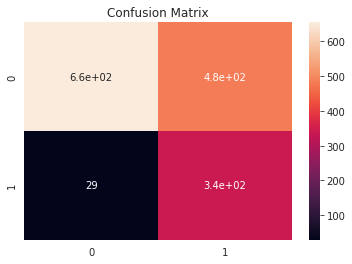

In [80]:
from sklearn.metrics import confusion_matrix #for confusion matrix

cm = confusion_matrix(val_targets,val_preds)

#visualize the confusion matrix 
sns.heatmap(cm,annot=True)
plt.title('Confusion Matrix')